# Setup

In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'sagemaker/DEMO-blazingtext-text8' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::815969174475:role/service-role/AmazonSageMaker-ExecutionRole-20190615T001026
sagemaker-us-east-1-815969174475


# Data Ingestion

In [2]:
# !wget http://mattmahoney.net/dc/text8.zip -O text8.gz
# Uncompressing
# !unzip ja.text8.zip

In [3]:
train_channel = prefix + '/train'
sess.upload_data(path='ja.text8', bucket=bucket, key_prefix=train_channel)
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)

In [4]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# Training Setup

In [5]:
region_name = boto3.Session().region_name

In [6]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


# Training the BlazingText model for generating word vectors

In [7]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [8]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

In [9]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [10]:
bt_model.fit(inputs=data_channels, logs=True)

2019-07-16 09:41:57 Starting - Starting the training job...
2019-07-16 09:41:58 Starting - Launching requested ML instances......
2019-07-16 09:43:02 Starting - Preparing the instances for training......
2019-07-16 09:44:24 Downloading - Downloading input data
2019-07-16 09:44:24 Training - Training image download completed. Training in progress..
Arguments: train
Found 10.2.86.168 for host algo-1
Found 10.2.116.47 for host algo-2
Arguments: train
Found 10.2.86.168 for host algo-1
Found 10.2.116.47 for host algo-2
[07/16/2019 09:44:36 WARNING 140633757001536] Loggers have already been setup.
[07/16/2019 09:44:36 WARNING 140633757001536] Loggers have already been setup.
[07/16/2019 09:44:36 INFO 140633757001536] nvidia-smi took: 0.0251929759979 secs to identify 0 gpus
[07/16/2019 09:44:36 INFO 140633757001536] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[07/16/2019 09:44:36 INFO 140633757001536] Number of hosts: 2, master IP address: 10.2.86.168, host I

# Hosting / Inference

In [11]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!

# Getting vector representations for words

In [12]:
words = ["自動車", "女性"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs = json.loads(response)
print(vecs)

[{'vector': [0.3537117838859558, 0.44674384593963623, -0.5150874853134155, -0.05227859318256378, 0.23508283495903015, 0.25164806842803955, 0.20792976021766663, -0.2903493344783783, 0.6014589071273804, -0.16497835516929626, -0.056705426424741745, 0.035586774349212646, -0.44098585844039917, -0.05656742304563522, 0.06283891201019287, 0.40982598066329956, -0.2859296500682831, 0.599833071231842, -0.08278888463973999, 0.17041641473770142, -0.4632934331893921, -0.23663994669914246, -0.137947216629982, -0.1516418308019638, -0.19362479448318481, 0.6123743057250977, 0.613235592842102, -0.2190054953098297, -0.08642154932022095, -0.6164255738258362, 0.1701967716217041, -0.4395659863948822, 0.26515480875968933, -0.14699313044548035, -0.34508275985717773, -0.0013590784510597587, -0.739748477935791, 0.2641482949256897, 0.06976877152919769, 0.006595666520297527, -0.35805821418762207, -0.13625115156173706, 0.6977356672286987, -0.011353341862559319, 0.3983643352985382, -0.08801382780075073, 0.0814437642

# Evaluation

In [13]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [14]:
!tar -xvzf model.tar.gz

vectors.txt
vectors.bin
eval.json


In [15]:
!cat eval.json

{
    "EN-WS-353-ALL.txt": {
        "not_found": 209, 
        "spearmans_rho": 0.24542449281287299, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 152, 
        "spearmans_rho": 0.11658980273442798, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 121, 
        "spearmans_rho": 0.367619048402975, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.24321111465009196
}

In [16]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
    

In [20]:
type(word_vecs)
word_vecs.shape

(400, 100)

In [21]:
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [22]:
type(word_vecs)
word_vecs.shape

(400, 100)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

In [24]:
!sudo yum install -y ipa-gothic-fonts

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper
amzn-main                                                | 2.1 kB     00:00     
amzn-updates                                             | 2.5 kB     00:00     
libnvidia-container/x86_64/signature                     |  488 B     00:00     
libnvidia-container/x86_64/signature                     | 2.0 kB     00:00 !!! 
nvidia-container-runtime/x86_64/signature                |  488 B     00:00     
nvidia-container-runtime/x86_64/signature                | 2.0 kB     00:00 !!! 
nvidia-docker/x86_64/signature                           |  488 B     00:00     
nvidia-docker/x86_64/signature                           | 2.0 kB     00:00 !!! 
Package ipa-gothic-fonts-003.02-4.2.2.amzn1.noarch already installed and latest version
Nothing to do


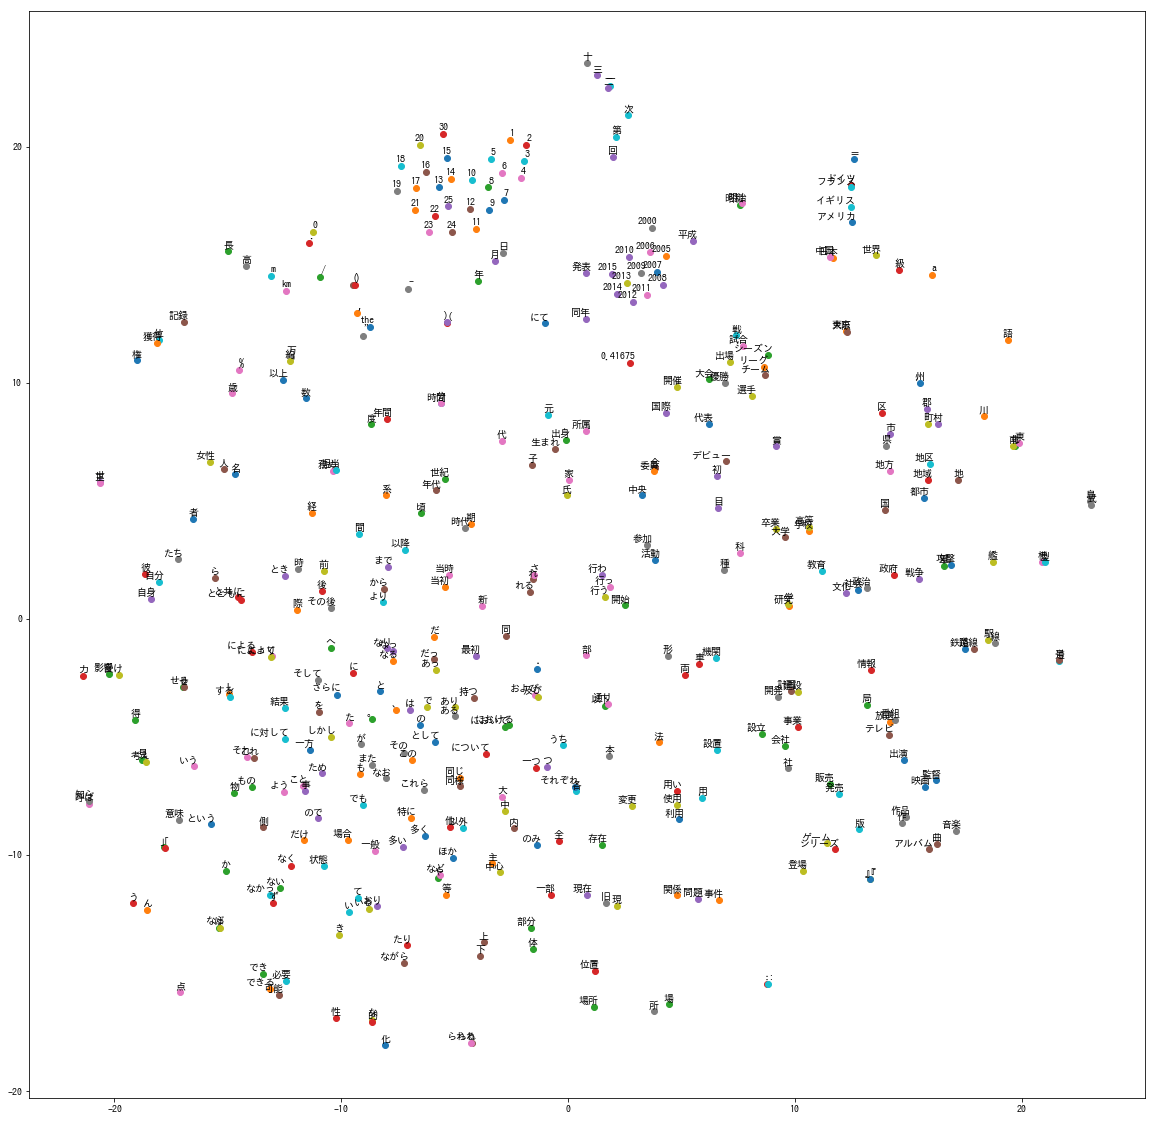

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
 
mpl.font_manager._rebuild() #キャッシュの削除
plt.rcParams['font.family'] = 'IPAGothic' # インストールしたフォントを指定


def plot(embeddings, labels):
    plt.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.savefig('image.png')
    plt.show()

plot(two_d_embeddings, labels)

# K-Means modelの学習
- SageMakerの組み込みアルゴリズムを用いたクラスタリングは[こちら](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb)のサンプルコードを参ご考に下さい。
- 今回クラスタ数を10としておりますが、データやユースケースに依存するハイパーパラメータになりますので、調整が必要です。

In [26]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-east-1-815969174475/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-815969174475/kmeans_example/output


In [27]:
word_vecs32 = word_vecs.astype('float32')
kmeans.fit(kmeans.record_set(word_vecs32))

## モデルによる推論の準備

In [29]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

## クラスタリングモデルの評価

In [30]:
result = kmeans_predictor.predict(word_vecs32)
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
for cluster in range(10):
    words = [word for l, word in zip(clusters, labels) if int(l) == cluster]
    print('============================================')
    print('クラスタ{}に属する単語は下記となります'.format(cluster))
    print(words)

クラスタ0に属する単語は下記となります
['年', '（', '）', '月', '日', '1', '2', '3', '4', '5', '6', '10', '7', '8', '9', '12', '11', '20', '15', '30', '16', '18', '13', '14', '19', '17', '21', '25', '24', '23', '22']
クラスタ1に属する単語は下記となります
['の', '、', '。', 'に', 'は', 'た', 'が', 'て', 'と', 'れ', 'さ', 'ある', 'いる', 'から', 'い', 'として', 'なっ', 'れる', 'この', 'その', 'られ', 'よう', 'また', 'なる', 'もの', 'おり', 'これ', 'より', '化', 'なり', 'られる', '本', '呼ば', 'つ', 'なお', '以下', '中心', '一部', '主', 'さらに', 'いう', '多い', '同じ', 'これら', '変更', '特に', '当初', '同様', '一つ', 'それぞれ', '通り']
クラスタ2に属する単語は下記となります
['を', 'で', 'し', 'する', 'も', '「', '」', 'こと', 'な', 'や', 'など', 'ない', '的', 'ため', '人', 'あっ', '第', '者', 'へ', '後', 'まで', 'あり', 'という', '中', 'だ', 'により', 'によって', 'か', 'による', '時', '一', 'ず', 'だっ', 'なかっ', '名', 'において', '性', '回', '上', '間', '場合', 'せ', 'なく', '大', 'その後', 'しかし', '多く', 'できる', 'ば', 'について', '二', 'それ', '使用', '数', '他', '当時', '受け', '存在', '目', '内', '前', '等', '同', '万', '型', 'および', '約', '次', 'のみ', '系', 'でき', '三', '可能', '彼', '法', 'における', 'たち', '長', '新', '以降', '際', '下', '式', '時間'

## 入力する任意の文字列に対する、似たグループ(類似度が高い単語の集まり)の特定

In [62]:
input_word = '自動車'

In [63]:
new_word = [input_word]
payload = {"instances" : new_word}
response = bt_endpoint.predict(json.dumps(payload))
new_vec = normalize(np.array(json.loads(response)[0]['vector']).reshape(1, -1), copy=False, return_norm=False).astype('float32')

In [64]:
result = kmeans_predictor.predict(new_vec)

In [67]:
similar_words = [word for l, word in zip(clusters, labels) if int(l) == int(result[0].label['closest_cluster'].float32_tensor.values[0])]
print('入力された文字列は「{}」です'.format(input_word))
print('====類似性の近い単語群は下記です。＝＝＝＝＝＝')
print(similar_words)

入力された文字列は「自動車」です
====類似性の近い単語群は下記です。＝＝＝＝＝＝
['日本', '現在', '部', '世界', '行わ', '国', '会', '東京', '大学', '号', '活動', '学校', 'う', 'アメリカ', '初', '研究', '地域', '行っ', 'き', '代表', '語', '形', ':', '賞', '0.41675', '用', '開始', '車', '分', '所', '局', 'ドイツ', '参加', 'フランス', '全', '開催', '学', '監督', '世紀', '級', '計画', '社', '設置', 'にて', '場', '国際', 'イギリス', '都市', '事業', '教育', '会社', '種', '建設', '大阪', '中国', '委員', '＝', '設立', '政府', '機関', '地区', '中央', '文化', '科', 'ん', '艦', '路線', '高等']
